In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2
import nltk as nltk
import re
import data_cred as cred
import folium
import seaborn as sns
from textblob import TextBlob
import string
from wordcloud import WordCloud 
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aperniah\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
def connect_db(user,password,host,port,database):
    connection = psycopg2.connect(user = user,
                                  password = password,
                                  host = host,
                                  port = port,
                                  database = database)
            
    return connection

In [3]:
def cursor_init(connection):
    cursor = connection.cursor()
    cursor.execute("SELECT version();")
    record = cursor.fetchone()
    print("You are connected to - ", record,"\n")  
    return cursor

In [4]:
def select_tuits(topic,cursor):
    #json.dumps(x)
    script = f"Select tweet,topic,city_searched,country_searched FROM data_tweets where topic = '{topic}'"
    cursor.execute(script)
    return cursor

In [5]:
def transform_data(cursor):
    tweets = []
    columns = cursor.description
    for t in cursor.fetchall():
        tweet = t[0]
        tweets.append([tweet['id'], 
                    tweet['full_text'],
                    tweet['retweet_count'],
                    tweet['favorite_count'],
                    tweet['created_at'],
                    tweet['user']['screen_name'], 
                    [i['screen_name'] for i in tweet['entities']['user_mentions']],
                    tweet['user']['description'],
                    tweet['user']['verified'],
                    tweet['user']['location'],
                    tweet['user']['statuses_count'], 
                    tweet['user']['followers_count'], 
                    tweet['user']['friends_count'], 
                    tweet['user']['favourites_count'], 
                    tweet['user']['created_at'], 
                    tweet['user']['profile_image_url'],
                    tweet['user']['created_at'],
                    t[1],
                    t[2],
                    t[3]])

    return tweets

In [6]:
topico_a='trump'
topico_b='biden'
topico_a2='donald trump'
topico_b2='joe biden'
columns = ['id' , 'full_text', 'retweet_count', 'favorite_count', 'created_at', 'user_screen_name' , 'user_mentions', 'user_description', 'user_verified', 'user_location', 'user_statuses_count' , 'user_followers_count' , 'user_friends_count' , 'user_favourites_count' , 'user_created_at' , 'user_profile_image_url', 'user_created_at', 'topic','city_searched','country_searched']

In [7]:
connection = connect_db(cred.database_user,cred.database_pass,"192.168.0.22",'5432','data_tweets')
cursor_a = cursor_init(connection)
cursor_b = cursor_init(connection)

You are connected to -  ('PostgreSQL 12.4 (Ubuntu 12.4-1.pgdg20.04+1) on x86_64-pc-linux-gnu, compiled by gcc (Ubuntu 9.3.0-10ubuntu2) 9.3.0, 64-bit',) 

You are connected to -  ('PostgreSQL 12.4 (Ubuntu 12.4-1.pgdg20.04+1) on x86_64-pc-linux-gnu, compiled by gcc (Ubuntu 9.3.0-10ubuntu2) 9.3.0, 64-bit',) 



In [8]:
d_a = select_tuits(topico_a, cursor_a)

In [9]:
d_b = select_tuits(topico_b, cursor_b)

In [10]:
data_a = transform_data(d_a)


In [11]:
data_b = transform_data(d_b)


In [12]:
df_a = pd.DataFrame(data_a,columns=columns)
df_b = pd.DataFrame(data_b,columns=columns)


In [13]:
df_a['created_at'] = df_a['created_at'].apply(pd.to_datetime)
df_a['user_created_at'] = df_a['user_created_at'].apply(pd.to_datetime)

In [14]:
df_a.count()[1],df_b.count()[1]

(39758, 6856)

0         1401
1          137
2         9535
3         2472
4         4813
         ...  
30967    17247
30968     1793
30969     2548
30970      779
30971       65
Name: user_followers_count, Length: 30972, dtype: int64

In [15]:
def transform2(text):
    stopWords = set(stopwords.words('spanish'))
    text = str(text)
    text = re.sub(r'@[A-Za-z0-9]+', ' ', text) # Remover menciones 
    text = re.sub(r'RT[\s]', ' ', text) # Remover RTs
    text = re.sub(r'#', ' ', text) # Remover # en el tweet
    text = re.sub(r'https?:\/\/\S+', ' ', text) #Remover links
    text = text.lower().replace('jaja','')
    text = text.lower().replace(' ja ','')
    text = text.lower().replace(' va ','')
    text = text.lower().replace(' si ','')
    text = text.lower().replace(' ser ','')
    #text = re.sub(r'',' ',text)
    words = text.lower().split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    stripped = [re_punc.sub('', w) for w in words]
    no_garbage = [w for w in stripped if not w in stopWords]
    return (' '.join(no_garbage))

In [16]:
def transform(text):
    text = str(text)
    text = re.sub(r'@[A-Za-z0-9]+', ' ', text) # Remover menciones 
    text = re.sub(r'RT[\s]', ' ', text) # Remover RTs
    text = re.sub(r'#', ' ', text) # Remover # en el tweet
    text = re.sub(r'https?:\/\/\S+', ' ', text) #Remover links
    text = text.lower().replace('jaja','')
    #text = re.sub(r'',' ',text)
    words = text.lower().split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    stripped = [re_punc.sub('', w) for w in words]
    return (' '.join(stripped))

In [17]:
df_a['tuit_text_transform'] = df_a ['full_text'].apply(transform)
df_b['tuit_text_transform'] = df_b ['full_text'].apply(transform)
df_a['tuit_text_transform2'] = df_a ['full_text'].apply(transform2)
df_b['tuit_text_transform2'] = df_b ['full_text'].apply(transform2)

In [18]:
df_b.head()

,id,full_text,retweet_count,favorite_count,created_at,user_screen_name,user_mentions,user_description,user_verified,user_location,...,user_friends_count,user_favourites_count,user_created_at,user_profile_image_url,user_created_at,topic,city_searched,country_searched,tuit_text_transform,tuit_text_transform2
0,1313489781465194502,@marcorubio Correcto mi estimado Marco... Los ...,0,0,Tue Oct 06 14:42:22 +0000 2020,TheAlterNativo,[marcorubio],"Músico, Adicto a las series de TV.\n*CUENTA RE...",False,Caracas - Venezuela,...,0,2,Sat May 21 18:34:30 +0000 2011,http://pbs.twimg.com/profile_images/1107447111...,Sat May 21 18:34:30 +0000 2011,biden,Caracas,Venezuela,correcto mi estimado marco los dictadores asqu...,correcto estimado marco dictadores asquerosos ...
1,1315283640331501568,@cmalass Preocupantes apoyos a Biden.,0,1,Sun Oct 11 13:30:31 +0000 2020,MarioWagner64,[cmalass],Liberal.,False,"Pilar, Argentina",...,3780,37365,Thu May 31 22:22:14 +0000 2012,http://pbs.twimg.com/profile_images/1134866081...,Thu May 31 22:22:14 +0000 2012,biden,Córdoba,Argentina,preocupantes apoyos a biden,preocupantes apoyos biden
2,1315279495667109891,@LANACION o sea que si esta piba retrógrada pi...,0,1,Sun Oct 11 13:14:03 +0000 2020,aguviru,[LANACION],Geóloga. No apoyo a las feminazis. No cierro n...,False,"Córdoba, Argentina",...,759,40882,Fri Feb 21 14:06:00 +0000 2014,http://pbs.twimg.com/profile_images/1097258947...,Fri Feb 21 14:06:00 +0000 2014,biden,Córdoba,Argentina,o sea que si esta piba retrógrada pide que vot...,queesta piba retrógrada pide voten biden hacer...
3,1315275595836723200,"#Madonna quiere a #KamalaHarris, compañera de ...",0,0,Sun Oct 11 12:58:33 +0000 2020,VozdeRosario,[],🎙El periodismo es libre o es una farsa\n👥https...,False,Rosario - Santa Fe - Argentina,...,1550,1,Fri Jul 15 01:44:51 +0000 2016,http://pbs.twimg.com/profile_images/1138635711...,Fri Jul 15 01:44:51 +0000 2016,biden,Córdoba,Argentina,madonna quiere a kamalaharris compañera de fór...,madonna quiere kamalaharris compañera fórmula ...
4,1315265815403532288,"@miguelhotero @abc_mundo Si leen ""el artículo""...",0,0,Sun Oct 11 12:19:41 +0000 2020,GustavoRdgz,"[miguelhotero, abc_mundo]","Parezco buena gente, pero muero por comer una ...",False,"Córdoba, Argentina",...,876,7707,Mon Apr 12 02:15:45 +0000 2010,http://pbs.twimg.com/profile_images/1274388585...,Mon Apr 12 02:15:45 +0000 2010,biden,Córdoba,Argentina,mundo si leen el artículo no es más que un fol...,mundoleen artículo folleto propagandístico ata...


In [19]:
df_a.head()

,id,full_text,retweet_count,favorite_count,created_at,user_screen_name,user_mentions,user_description,user_verified,user_location,...,user_friends_count,user_favourites_count,user_created_at,user_profile_image_url,user_created_at,topic,city_searched,country_searched,tuit_text_transform,tuit_text_transform2
0,1313731899035185153,¿Como la gente medianamente decente en un sent...,0,0,2020-10-07 06:44:27+00:00,divianb,[],Religión y Estado van por separado.,False,"San José, Costa Rica",...,5341,38049,2009-01-29 04:00:28+00:00,http://pbs.twimg.com/profile_images/1265672282...,2009-01-29 04:00:28+00:00,trump,Caracas,Venezuela,¿como la gente medianamente decente en un sent...,¿como gente medianamente decente humanismo al...
1,1313731571111919618,Nadie votó en contra de Venezuela. Nadie votam...,0,0,2020-10-07 06:43:09+00:00,mariape0a,[],Enseñé en escuelas de riesgo social Fui a La H...,False,Argentina,...,375,11480,2013-04-12 01:39:08+00:00,http://pbs.twimg.com/profile_images/1314677695...,2013-04-12 01:39:08+00:00,trump,Caracas,Venezuela,nadie votó en contra de venezuela nadie votamo...,nadie votó venezuela nadie votamos bolsonaro p...
2,1313730431934750720,@1333Despierta @POTUS_Trump_ESP @FLOTUS Espero...,0,0,2020-10-07 06:38:37+00:00,carmentvc,"[1333Despierta, POTUS_Trump_ESP, FLOTUS]","Madre de dos hijos, disfruto de las barbacoas ...",False,valencia,...,1334,6355,2011-02-02 21:44:07+00:00,http://pbs.twimg.com/profile_images/1266272348...,2011-02-02 21:44:07+00:00,trump,Caracas,Venezuela,trumpesp espero que no,trumpesp espero
3,1313729917889261570,Por qué sí me gusta Donald Trump https://t.co/...,0,0,2020-10-07 06:36:35+00:00,corradi_gar,[jcsosazpurua],Economista UCV Asesor Consultor,False,"Nueva Esparta, Venezuela",...,1747,892,2013-07-08 08:47:36+00:00,http://abs.twimg.com/sticky/default_profile_im...,2013-07-08 08:47:36+00:00,trump,Caracas,Venezuela,por qué sí me gusta donald trump vía,gusta donald trump vía
4,1313729722484957185,@rosapantin1301 no entiendo que tiene que ver ...,0,0,2020-10-07 06:35:48+00:00,Ynes15541165,[rosapantin1301],,False,Puerto ordaz,...,83,722,2019-04-18 19:53:17+00:00,http://pbs.twimg.com/profile_images/1118973044...,2019-04-18 19:53:17+00:00,trump,Caracas,Venezuela,no entiendo que tiene que ver la foto de obama...,entiendo ver foto obama trump mussolini


In [20]:
def set_sentiment(text):
    sentiment=0
    text = str(text)
    if text != '':
        analysis = TextBlob(text)
        if len(analysis)>3:
            #if analysis.detect_language() == 'es':
            #analysis = analysis.translate(from_lang='es',to='en').sentiment
            sentiment = analysis.polarity
    return sentiment

In [21]:
df_a['polarity'] = df_a['full_text'].apply(set_sentiment)
df_b['polarity'] = df_b['full_text'].apply(set_sentiment)

In [22]:
df_a['polarity'].describe()

count    39758.000000
mean         0.001067
std          0.102376
min         -1.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: polarity, dtype: float64

In [23]:
df_b['polarity'].describe()

count    6856.000000
mean        0.000630
std         0.103361
min        -1.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: polarity, dtype: float64

In [24]:
text_a = ' '.join(df_a.tuit_text_transform2)
text_b = ' '.join(df_b.tuit_text_transform2)
text_a = text_a.lower().replace(topico_a2,'')
text_b = text_b.lower().replace(topico_b2,'')
text_a = text_a.lower().replace(topico_a,'')
text_b = text_b.lower().replace(topico_b,'')
#
text_a = text_a.lower().replace(topico_b2,'')
text_b = text_b.lower().replace(topico_a2,'')
text_a = text_a.lower().replace(topico_b,'')
text_b = text_b.lower().replace(topico_a,'')
#

In [25]:
wordcloud_a = WordCloud(width=1024, height=720, background_color='black', min_font_size=14).generate(text_a)
wordcloud_b = WordCloud(width=1024, height=720, background_color='black', min_font_size=14).generate(text_b)

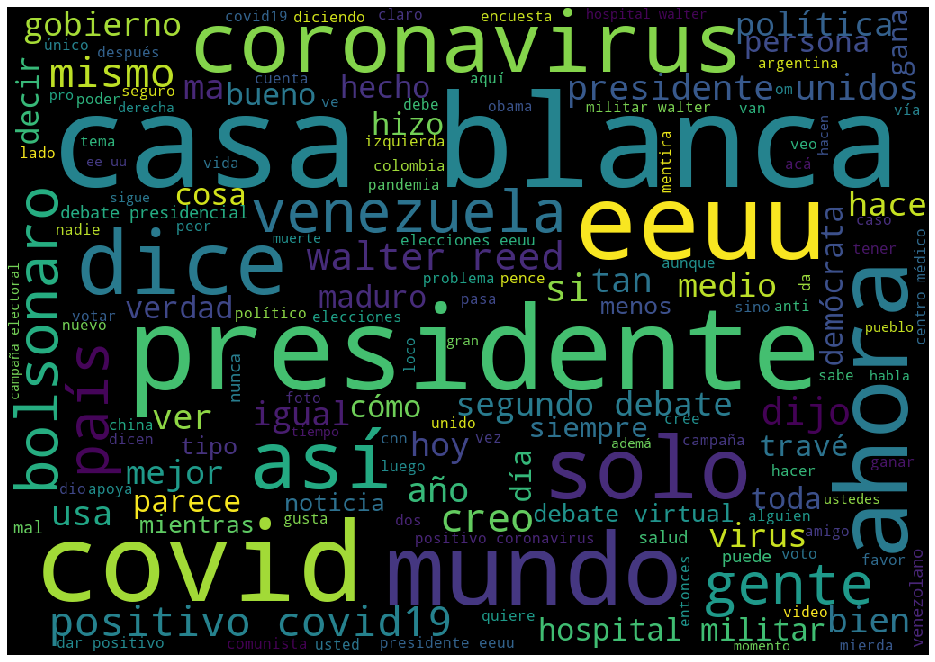

In [26]:
plt.figure(figsize=(16,9), facecolor=None)
plt.imshow(wordcloud_a)
plt.axis('off')
plt.tight_layout(pad=0)
plt.savefig('images/a_wordcloud.png')
plt.show()


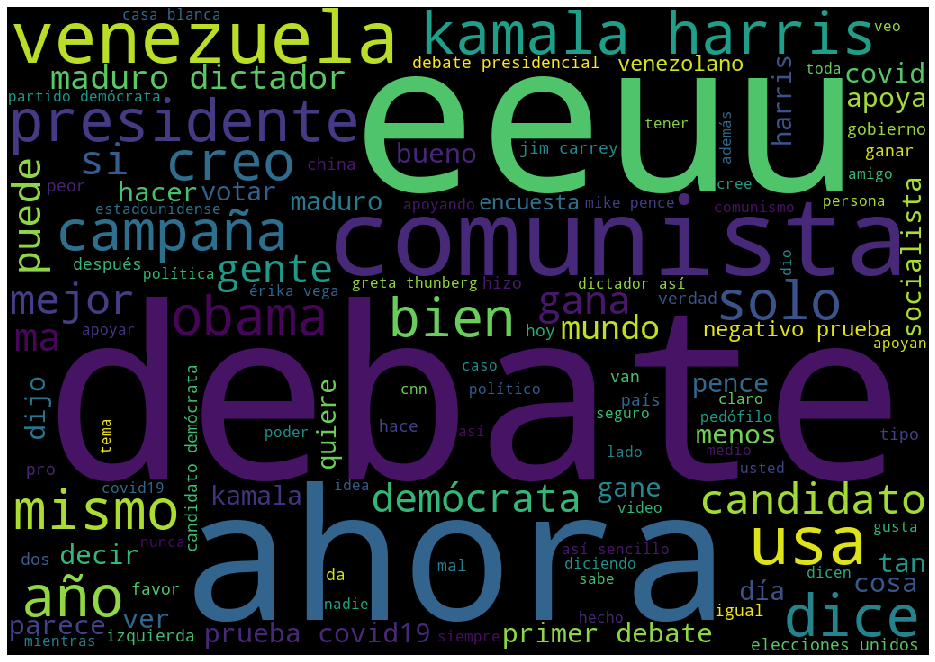

In [27]:
plt.figure(figsize=(16,9), facecolor=None)
plt.imshow(wordcloud_b)
plt.axis('off')
plt.tight_layout(pad=0)
plt.savefig('images/b_wordcloud.png')
plt.show()


In [28]:
df_af = df_a[df_a['polarity'] != 0] 
df_bf = df_b[df_b['polarity'] != 0] 

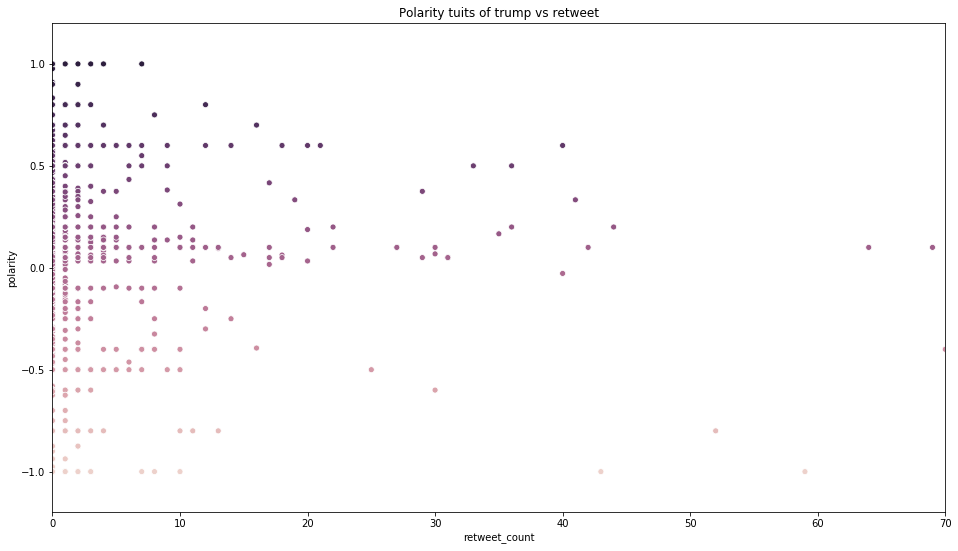

In [29]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 9)
plt.title(f'Polarity tuits of {topico_a} vs retweet')
plt.xlim(0,70)
plt.ylim(-1.2,1.2)
sns.scatterplot(data=df_af, x='retweet_count', y="polarity", hue="polarity", legend=False, ax=ax)
plt.savefig('images/a_polarity.png')

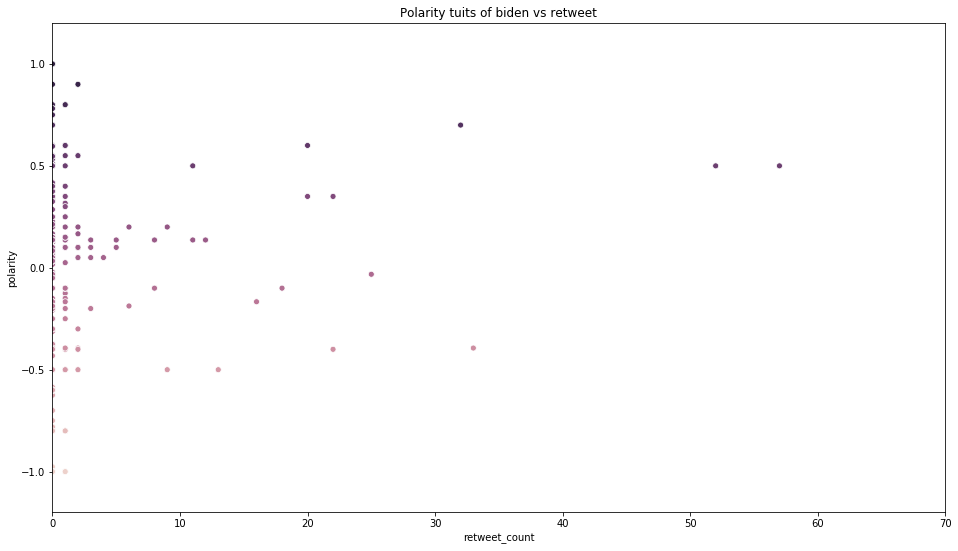

In [30]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 9)
plt.title(f'Polarity tuits of {topico_b} vs retweet')
plt.xlim(0,70)
plt.ylim(-1.2,1.2)
sns.scatterplot(data=df_bf, x='retweet_count', y="polarity", hue="polarity", legend=False, ax=ax)
plt.savefig('images/b_polarity.png')

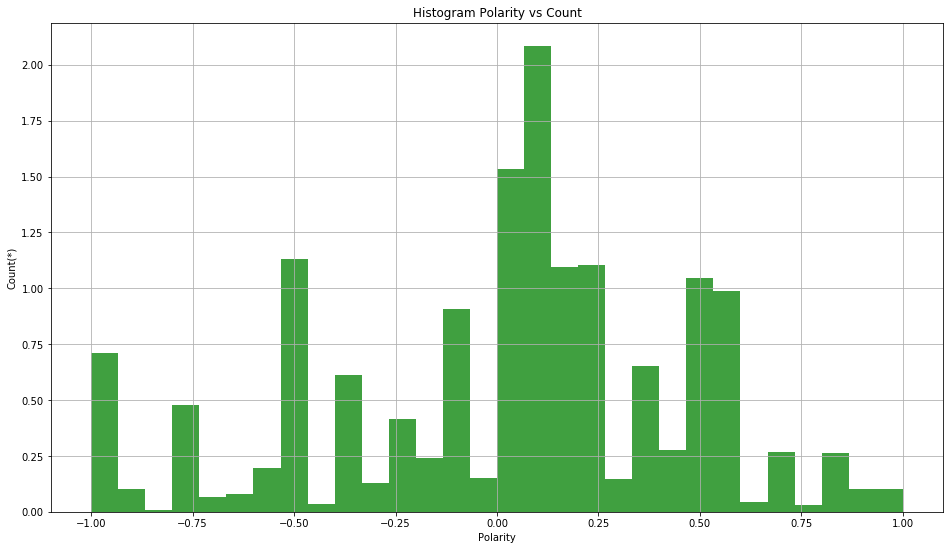

In [31]:
plt.figure(figsize=(16,9), facecolor=None)
plt.hist(df_af['polarity'], bins=30, density=True, facecolor='g', alpha=0.75)
plt.xlabel('Polarity')
plt.ylabel('Count(*)')
plt.title('Histogram Polarity vs Count')
plt.grid(True)
plt.show()

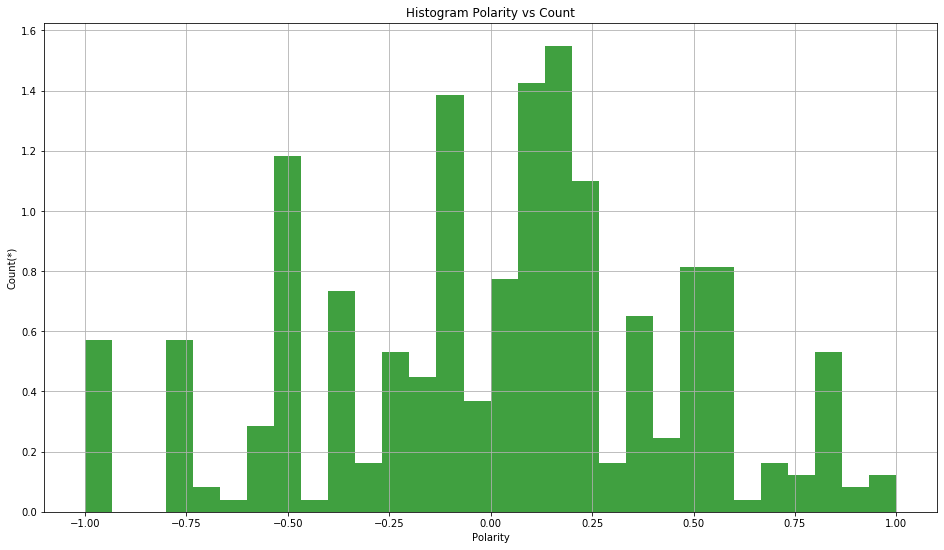

In [32]:
plt.figure(figsize=(16,9), facecolor=None)
plt.hist(df_bf['polarity'], bins=30, density=True, facecolor='g', alpha=0.75)
plt.xlabel('Polarity')
plt.ylabel('Count(*)')
plt.title('Histogram Polarity vs Count')
plt.grid(True)
plt.show()

In [57]:
def geo_to_number(list_geo):
    geo_return = []
    for geo in list_geo:
        geo = geo[0].split(',')
        geo = [float(geo[0]),float(geo[1])]
        geo_return.append(geo)
    return list(geo_return)

In [60]:
map1 = folium.Map(
    location=[-13.9837562,-56.8230086],
    zoom_start=4,
    #tiles='cartodbpositron',
    tiles='CartoDB dark_matter'
)
for geo in geo_to_number(cred.geo_data):
    folium.Marker(location=geo, icon=folium.Icon(color='blue') ).add_to(map1)
    #folium.CircleMarker(location=geo).add_to(map1)
map1.save("images/my_map.html")
map1


[-33.4672832, -70.652568]
[-34.6025287, -58.3796486]
[-23.5861315, -46.6582803]
[-34.8207362, -56.3765221]
[-31.3992876, -64.2643839]
[-32.8832979, -68.8760287]
[-31.6145747, -60.6980372]
[7.7721289, -72.226306]
[10.2241386, -67.3411383]
[10.4686988, -67.0304528]
[4.657911, -74.0959651]
[-12.0448728, -77.0488376]
